## Dataset Selection

Select a dataset identically to the way you selected for lab one or lab three (table data or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains three or more classes to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

## Grading Rubric

### Preparation (15 points total)
[5 points] (mostly the same processes as from lab four) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?

[10 points] (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

### Evaluation (30 points total)
[15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

Important: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be regarded as a conceptual error and graded accordingly. 
### Modeling (45 points total)
[20 points] Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
When instantiated, use a selectable nonlinearity function for the first layer: either sigmoid or linear 
Use a selectable cost function when instantiated: either quadratic or cross entropy

[15 points] Tune the hyper-parameters of your MLP model (at least two hyper-parameters). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. Visualize the evaluation metric(s) versus the hyper-parameters. Conclude what combination of parameters are best.

[10 points] Compare the performance of your MLP training procedure to scikit-learn. Which implementation is better in terms of generalization performance, computation time, and memory used while training?

### Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea: Add support for more than one hidden layer or a different nonlinear activation (i.e., softmax, tanh). Please note that different activation functions might require different weight initializations to work well. 

In [1]:
import os
import sys
import random
import copy
import warnings
from random import randint
import _pickle as cPickle

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.neural_network import MLPClassifier
from scipy.misc import imread
from scipy.special import expit
import pywt # conda install -c conda-forge pywavelets
from skimage.filters import roberts
from skimage.feature import daisy
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# a helper plotting function
def plot_gallery(imgs, labels, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(imgs[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(labels[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [3]:
###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./imgs/
###

def get_images(): # stuck this in a function to clean up memory 
    dics = []
    for root, directory, files in os.walk('imgs'):
        for f in files:
            if 'data_batch' in f or 'test_batch' in f:
                with open(root+'/'+f, 'rb') as fo:
                    dics.append(cPickle.load(fo, encoding='latin1'))

    img_color = []
    img_labels = []
    for dic in dics:
        for i in range(len(dic['data'])):
            img_color.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
            img_labels.append(dic['labels'][i]) # int representing the label

    img_color = np.array(img_color)
    img_labels = np.array(img_labels)

    # grab the mapping between label names and IDs
    print('Labels:')
    labels = {}
    with open('./imgs/batches.meta', 'rb') as fo:
        labels_tmp = cPickle.load(fo, encoding='latin1')
        for i in range(len(labels_tmp['label_names'])):
            labels[i] = labels_tmp['label_names'][i]
            print(i, "-->", labels_tmp['label_names'][i])
    print()

    img_label_names = np.array([labels[x] for x in img_labels])

    def toGrayscale(img):
        r, g, b = img[:1024], img[1024:2048], img[2048:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    img_gray = np.array([toGrayscale(x) for x in img_color])
    
    return (img_color, img_gray, img_labels, img_label_names)

img_color, img_gray, img_labels, img_label_names = get_images()
img_gray = img_gray
img_labels = img_labels
print("n_samples: {}".format(len(img_gray)))
print("n_features: {}".format(len(img_gray[0])))
print("n_classes: {}".format(len(np.unique(img_labels))))
print("Original Image Size: {} x {}".format(32, 32))

Labels:
0 --> airplane
1 --> automobile
2 --> bird
3 --> cat
4 --> deer
5 --> dog
6 --> frog
7 --> horse
8 --> ship
9 --> truck

n_samples: 60000
n_features: 1024
n_classes: 10
Original Image Size: 32 x 32


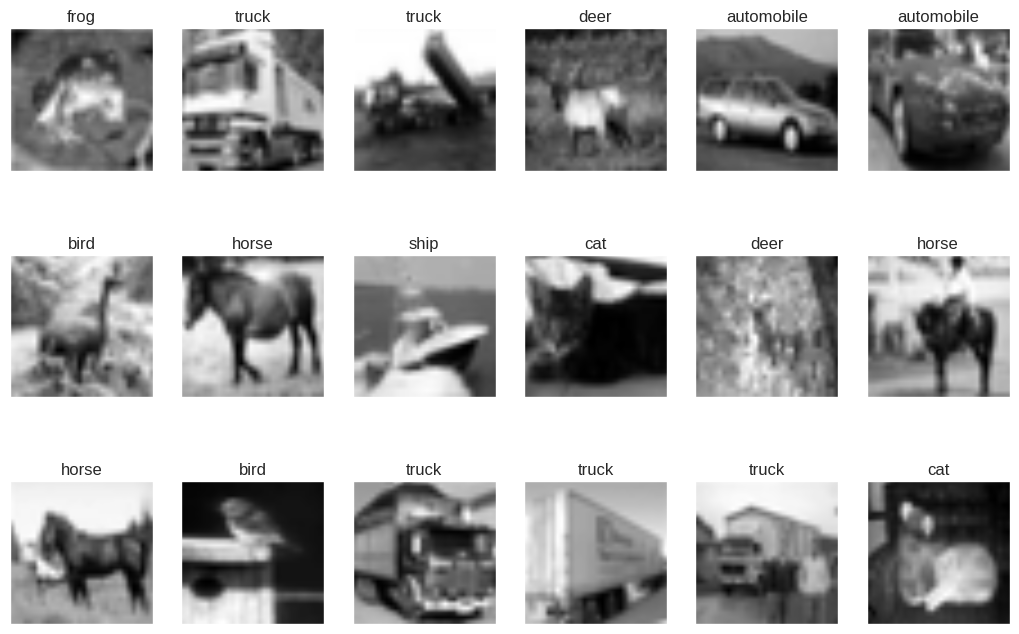

In [4]:
plot_gallery(img_gray, img_label_names, 32, 32) 

## Image Preprocessing

To determine the best list of steps for preprocessing our images before training and predicting using our classifier, we started out by trying to get the best score possible using SKLearn's Multi-Layer Perceptron classifier, a model that we can trust to perform reliably well, even at its default settings. According to Kaggle's leaderboards, the absolute highest score for this particular dataset was 95.5% accuracy using a convolutional neural network, which is what we strove for. Under the assumption that we have a classification model that works well, the key to this analysis is the successful preprocessing we do.

The first step along our journey was to try Principal Component Analysis. Theoretically technique would turn our 1024 data points into a much smaller number while at the same time generating a set of components that would hopefully expose the correlations between groups of pixels. Unfortunately, the technique didn't pan out, only giving us about 12% accuracy score, which is just a little better than random guessing. We assume PCA didn't work because it looks at all the pixels on a global scale. Groups of pixels that seem to be correlated in a picture from a class might not be correlated with another picture from the same class, but taken from a different point of view.

The next step was trying an edge-detection algorithm. For this, we used Roberts' algorithm as implemented in Scikit-Image. This algorithm returned a 32px x 32px image (the same size as our input), with only the detected edges showing up in the image. This technique, even though it takes no color or texture information into account, gave us around a 30% accuracy score. On top of the edge detection, we performed a Haar wavelet transform of the images in order to further show us the correlations between local groups of pixels. This transformation helped, but only marginally, giving us about a 32% accuracy. 

After being unsatisfied with out results, we turned to academic papers to help us find our solution. According to one such paper, Shouhan Lin, Roland Memisevic, and Kishore Konda experimented with the same CIFAR-10 dataset and achieved a 56.84% accuracy only using a neural network. For preprocessing they used global contrast normalization to create a zero mean, followed by PCA whitening. We implemented these techniques as they described hoping to achieve repeatable results. While the GCN algorithm helped marginally, we could only achieve a \<15% accuracy score with the PCA-based techniques they used. We scrapped the PCA technique-family altogether and moved on.

Next, we simply fed unprocessed, flattened color images into the classifier. To our suprise, this actually gave us a 40% accuracy, which is significantly better than randomly guessing. However, it was still not the best.

Lastly, we thought about the problem some more and affirmed that a transformation that could look at local sections of the image and extract specific features would be necessary to achieve our goals. One such algorithm that fit this category was the DAISY Feature Extraction technique. We put 4 daisies on each image, each with two sets of 8 circles of radius 7, and each circle looking in 5 different directions, for a total of 340 features, which is much less than our original set of 1024 features. This technique finally gave us the key to the classification, giving us around 60% accuracy consistently. 

In the end, we stuck with using GCN followed by DAISY feature extraction on grayscale images. In the future, we could further extend this by taking color information into account (many images of the same class will be similarly-colored), or further exploring the ZCA techniques as suggested by the top contenders on Kaggle (perhaps we implemented them incorrectly).

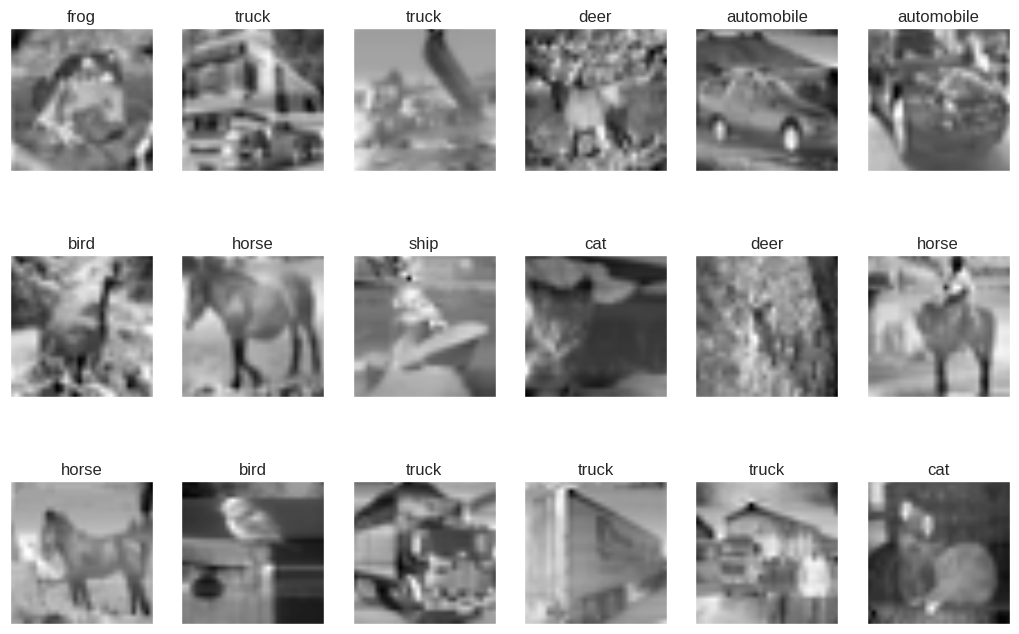

In [5]:
def global_contrast_normalization(x):
    x = x - x.mean(axis=1)[:, np.newaxis]
    normalizers = np.sqrt((x ** 2).sum(axis=1))
    x /= normalizers[:, np.newaxis]
    return x

# contrast normalization
normalized = np.array([np.concatenate(global_contrast_normalization(x.reshape((32, 32)))) for x in img_gray])
plot_gallery(normalized, img_label_names, 32, 32) 

In [6]:
daisies = np.array([np.concatenate(np.concatenate(daisy(x.reshape((32,32)), step=16, radius=7, rings=2, histograms=8, orientations=5))) for x in img_gray])

## Modeling

In [7]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.

# start with a simple base classifier, which can't be fit or predicted
# it only has internal functions to be used by classes that will subclass it
class TwoLayerPerceptronBase(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 first_func="sigmoid", cost_func="cross entropy"):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.first_func = first_func
        self.cost_func = cost_func
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights"""
        if self.first_func == "relu":
            init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
            W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))

            init_bound = np.sqrt(2. / (self.n_output_ + self.n_hidden + 1))
            W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        else: 
            W1_num_elems = (self.n_features_ + 1)*self.n_hidden
            W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
            W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W

            W2_num_elems = (self.n_hidden + 1)*self.n_output_
            W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
            W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        if self.cost_func == "cross entropy":
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        else: # quadratic
            cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if self.first_func == "sigmoid":
            A2 = self._sigmoid(Z1)
        elif self.first_func == "relu":
            A2 = self._relu(Z1)
        else: 
            A2 = Z1
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        
        # vectorized backpropagation
        if self.cost_func == "cross entropy":
            sigma3 = (A3-Y_enc)
        else: # quadratic
            sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
        
        if self.first_func == "sigmoid":
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        elif self.first_func == "relu":
            sigma2 = (W2.T @ sigma3) 
            Z1_with_bias = self._add_bias_unit(Z1,how='row')
            sigma2[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        else: # linear
            sigma2 = (W2.T @ sigma3)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    def score(self, x, y):
        res = self.predict(x)
        return accuracy_score(y, res)

In [8]:
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 first_func="sigmoid", cost_func="cross entropy"):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(n_hidden=n_hidden, C=C, epochs=epochs, eta=eta, random_state=random_state, first_func=first_func, cost_func=cost_func)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self

## Evaluation

### Scoring

We need to choose a method for scoring our classifier, out of accuracy, recall, precision, and F-score. For a start, let's define the four possible cases when classifying an image:

- True Positive: Image is of class X, and we correctly guessed class X. 
- True Negative: Image is of class X, and we correctly stated that it wasn't any of the other 9 classes. In our cases, a True Positive also comes with the benefit of having 9 True Negatives.
- False Positive: Image is of class X, and we incorrectly guessed class Y.
- False Negative: Image is of class X, and we didn't guess that it was X. Like the True Negative, if we have a False Positive, we also have a False Negative. 

In our case, because the True Positives and True Negatives are all paired up with each other, it would be safe to say that we only need to maximize one of them, as maximizing one intrinsically maximizes the other. As such, we can eliminate accuracy score, because we don't need to account for both. Additionally, because having a False Positive means we have a False Negative paired with it, we can weight each equally. We also want to minimize both False Positives and False Negatives. The only scoring method left that takes all these attributes into account is the F-score. In our case, we use the **F1 score**, as we want to weigh False Positives and Negatives equally.


### Cross-Validation

We also needed to choose a method for splitting our data set into smaller sets that more closely model a real-life scenario, as we don't get to train over every sample of data that comes in before needing to predict what its outcome will be. We have a couple of tools in our arsenal for cross-validation: simple train-test splits, K-folds, shuffle splits, and stratified K-fold or shuffle splits. Coming into the problem, there are a few properties of our dataset that we can use when making this decision. First off, we know that our set is perfectly balanced - there are exactly 6000 members of each class. Secondly, there is no need for any ordering of our set as it's not a time-series or any other ordered series. Lastly, there shouldn't be any bias in the ordering of members of a class. Because of these three characteristics, we believe that we could reliably pick any of the aforementioned techniques and still get _good_ results. However, some of the techniques are intrinsically better than the others. We do want one of the stratified techniques as there is no reason we should introduce a class imbalance into the mix when there was none before. We also want to actually use a cross-validation technique rather than a simple test-train split, as it helps us to try out every data sample in a training set. This leaves us with either Stratified K-Fold splits or Stratified Shuffle Splits. As randomly selecting X members of each class shouldn't introduce any bias and using a Shuffle Split has the potential to be faster, our final Cross-Validation technique will be the **Stratified Shuffle Split**.

In [9]:
x = daisies
y = img_labels

In [ ]:
params =  dict(n_hidden=100, 
              C=0.0001, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              cost_func="cross entropy",
              first_func="sigmoid")
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', TLPMiniBatch(**params))])
for train_index, test_index in cv.split(x, y):
    pl.fit(x[train_index], y[train_index])
    yhat = pl.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

In [10]:
# SKLearn's implementation
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', MLPClassifier())])
for train_index, test_index in cv.split(x, y):
    pl.fit(x[train_index], y[train_index])
    yhat = pl.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

f1 score: 0.568083173419
[1118 1325 1111  998 1334 1129 1312 1307 1221 1145]


In [ ]:
## Gridsearch 
params = dict(
    tlp__n_hidden = [50],
    tlp__eta = [.0001, .001, .1],
    tlp__epochs = [200],
    tlp__C = [0.0, .5, .2],
    tlp__first_func = ('sigmoid', 'linear', 'relu'),
    tlp__cost_func = ('quadratic', 'cross entropy'),
)

pl = Pipeline([('scaler', StandardScaler()), ('tlp', TLPMiniBatch())])
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
gs = RandomizedSearchCV(pl, params, n_jobs=-1, scoring='f1_macro', cv=cv)
gs.fit(x, y)
print('Best score: '+str(gs.best_score_))